In [ ]:
## These bar plots are of inferred frequency of short read sequencing, based on the loopseq haplotype analysis
### Assumptions: 
#### 1. C1549U appears only in a combo of 4 (with A1664G, C1718U and C2859U)
#### 2. C2859U freq that remains after reduction of section 1, is divided into C2859U + A1664G and the mut triplet A1664G + C1718U + C2859U
#### 3. C1718U freq after reduction of 1+2, marks the combo of C1718U + A1664G
#### 4. For A535G, there are two cases: 
##### MOI 1 - A535G is always 5% on its own and the rest is combined with A1664G (if there was less WT than 5%, 
##### 535 was reduced to fit WT)
##### MOI 0.01 - at t0-60 same as MOI 1. at t90 A535G + A1664G freq is equal to the freq in t60, 
##### the leftover is A535G alone. At ON A535G was divided into half alone half on A1664G (unless the WT was lower, 
##### then 535 on its own was reduced to fit WT freq)
#### 5. All combination frequencies were reduced from the original A1664G, the remainder is the freq of A1664G alone.

In [1]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from itertools import combinations
import re
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw

In [2]:
# mutation color dictionary
def COLORS():
    colors = {'T1764.0-': '#F50202',
             'A1664.0G': '#fca003',
             'A535.0G': '#5EC0D2',
             'T1440.0C': '#F1F87A',
             'T1440.0G': '#bfbb71',
             'A1443.0G': '#731f1f',
             'A1611.0G': '#6988b8',
             'C1724.0T': '#8FD95A',
             'A1744.0G': '#FBB3DD',
             'G1906.0A': '#A3A3A3',
             'C3358.0T': '#26451C',
             'G3114.0A': '#B37A42',
             'A1770.0G': '#b3b2ad',
             'G2310.0A': '#033E86',
             'A2626.0G': '#8FD95A',
             'C3299.0T': '#211785',
             'C1718.0T': '#4e0d8c',
             'T862.0C': '#880E05',
             'A2790.0T': '#DF36C6',
             'G1736.0A': '#CFFD2F',
             'C1549.0T': '#cd99f2',
             'G531.0A': '#DFC236',
             'C1050.0T': '#0D2291',
             'G1688.0T': '#13B908',
             'A2356.0G': '#2d16f7',
             'T170.0A': '#C60DC3',
             'A1673.0G': '#E2D492',
             'C2859.0T': '#972FFE',
             'T21.0C': 'grey',
             'T323.0A': 'black',
             'G2317.0A': '#E4CEFD',
             'C3378.0T': '#828282',
             'C1735.0T': '#AFF31E',
             'G1560.0A': '#646669',
             'T1829.0C': '#147040',
             'A2731.0G': '#B0F7FF',
             'G710.0A': "#ad8f61", 
             'C1056.0T': "#bd099f", 
             'A784.0G': "#875408", 
             'A1520.0G': "#92bf91",
             'A1829.0G': "#6e465a"}
    return colors

In [3]:
# this function will return a list of colors for all the mutations that are not in the color dict
def generate_colors(i):
    cmap_a = matplotlib.colormaps['Pastel1']
    cmap_b = matplotlib.colormaps['Dark2']  
    cmap_c = matplotlib.colormaps['tab20b'] 
    cmap_d = matplotlib.colormaps['Set3'] 
    
    if i < cmap_a.N:
        color = cmap_a(i % cmap_a.N)
    elif i < (cmap_a.N + cmap_b.N):
        color = cmap_b((i - cmap_a.N) % cmap_b.N)
    elif i < (cmap_a.N + cmap_b.N + cmap_c.N):
        color = cmap_c((i - cmap_a.N - cmap_b.N) % cmap_c.N)
    else:
        color = cmap_d((i - cmap_a.N - cmap_b.N - cmap_c.N) % cmap_d.N)    
    
    
    return color

In [4]:
# add data to each sample
def add_data(folder_segments, freqs):
    passage = int(re.findall(r"\d+", folder_segments[0])[0])
    freqs["passage"] = passage
    line = folder_segments[0][-1]
    freqs["line"] = line
    experiment = folder_segments[1]
    freqs["exp"] = experiment
    if (folder_segments[2] == "ON") and (folder_segments[4] != "sup"):
        time = 120
    elif folder_segments[2] == "stock":   ## use stock sample as t0
        time = 0
    elif (passage == 29) or (folder_segments[4] == "sup"):
        time = 150
    else:
        time = int(re.findall(r"\d+", folder_segments[2])[0])
    freqs["time"] = time
    if folder_segments[3] == "moi001":
        moi = 0.01
    elif folder_segments[3] == "moi1":
        moi = 1
    elif folder_segments[3] == "moi10":
        moi = 10
    else:
        print("MOI not clear in sample {}".format(folder_name))
        moi = None
    freqs["moi"] = moi
    freqs["sample_data"] = "moi{}".format(moi)
    freqs["sample_name"] = "t{}_moi{}".format(time, moi)
    freqs["mut_name"] = freqs.apply(lambda row: "".join([row["ref_base"], str(row["ref_pos"]), row["read_base"]]), axis=1)
    freqs.rename(columns={"frequency": "freq"}, inplace=True)
    freqs_filter = freqs.loc[(freqs["read_base"] != freqs["ref_base"]) & (freqs["ref_pos"] > 25) & 
                             (freqs["ref_pos"] < 3544)].copy().reset_index(drop=True)
    return freqs_filter

# function that creates a merged df for all samples (pyAccuNGS pipeline)
def get_freqs_pyAccuNGS(input_path, experiments):
    freqs_ls = []
    filter_list = ["large", "nofil", "_0min_", "sup", "p28B_ravit_15min_moi001_pellet_reseq"] # ignore irrelevant files in dir
    # get freqs files for each sample
    for root, dirs, files in os.walk(input_path):    
        folder_name = root.split("/")[-1]
        if (any(prefix in folder_name for prefix in experiments) and 
            ((all(fil not in folder_name for fil in filter_list)) or ("ravit_ON_moi001_sup" in folder_name)) and ("freqs.tsv" in files)):
            freq_path = os.path.join(root, "freqs.tsv")
            freqs = pd.read_csv(freq_path, sep="\t")
            folder_segments = folder_name.split("_")
            freqs_filter = add_data(folder_segments, freqs) # add sample data to df
            freqs_ls.append(freqs_filter)
    
    # merge all freqs files
    all_freqs = pd.concat(freqs_ls).reset_index(drop=True)
    return all_freqs

In [5]:
# assign colors to each mutation combination
def combo_color_match(mut_combos, color_legend):
    image_list = []
    for mut in mut_combos:
        hex_colors = []
        if (mut != "A1664.0G") & (mut != "other"):
            # we assume 1549 is always in a combo of 4 (with 1664, 1718, 2859)
            if mut == "C1549.0T":
                hex_colors.append(color_legend[mut])
                hex_colors.append(color_legend["C1718.0T"])
                hex_colors.append(color_legend["C2859.0T"])
                hex_colors.append(color_legend["A1664.0G"])
            # the triplet is a combo of 1664, 1718 & 2859
            elif mut == "triple":
                hex_colors.append(color_legend["C1718.0T"])
                hex_colors.append(color_legend["C2859.0T"])
                hex_colors.append(color_legend["A1664.0G"])
            elif mut == "535_alone":
                hex_colors.append(color_legend["A535.0G"])
            else:
                hex_colors.append(color_legend[mut])
                hex_colors.append(color_legend["A1664.0G"])        
        else:
            hex_colors.append(color_legend[mut])
        combo_image = create_color_sections(hex_colors)
        image_list.append(np.array(combo_image))
    return image_list


# convert hex color to rgb (for color segment images)
def hex_to_rgb(hex_color):
    # Convert hex color to RGB tuple
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))


# creates an image with color combo for plotting
def create_color_sections(hex_colors):
    width = 300
    height = 50
    col_amount = len(hex_colors)
    rgb_colors = []
    for color in hex_colors:
        rgb_colors.append(hex_to_rgb(color))
    image = Image.new("RGB", (width, height))
    draw = ImageDraw.Draw(image)
    for i, seg_color in enumerate(rgb_colors):
        draw.rectangle([i*width/col_amount, 0, (i+1)*width/col_amount, height], seg_color)
    return image

In [6]:
# create frequency plot using color images
def image_plot(freqs_df, times, experiment, images, ax):
    freqs_list = []
    for time in times:
        freqs_list.append(freqs_df[time].to_list())
    for i, freqs in enumerate(freqs_list):
        # parameters for column locations in plot
        if i < 7:      # added segment for column #8 (ON sup) to be a bit farther away (for dashed line)
            left = 0.5 + (i*4)
            right = left + 3
        else:
            left = 2.5 + (i*4)
            right = left + 3  
        
        freq_sum = 0
        for j, image in enumerate(images):
            # removes mutations with freqs under 1% to avoid segments that are too small to differ
            if (freqs[j] < 0.01) and ((j + 1) != len(freqs)):
                freqs[len(freqs) - 1] = freqs[len(freqs) - 1] + freqs[j]
                continue
            ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            # this part places the mutation combo images on the plot and adds a black border to each freq segment
            # I recommend not to change this segment even though it looks messy            
            if (freqs[j] >= 0.28):
                image = Image.new("RGBA", (50, 300), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-2, -10, 51, 301], outline="black", width=3)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif (freqs[j] >= 0.18):
                image = Image.new("RGBA", (100, 100), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([0, -10, 99, 100], outline="black", width=2)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif freqs[j] >= 0.12:
                image = Image.new("RGBA", (50, 300), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-2, -10, 51, 298], outline="black", width=3)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif freqs[j] >= 0.08:
                image = Image.new("RGBA", (50, 300), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-3, -10, 52, 298], outline="black", width=4)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif (freqs[j] >= 0.04) and not (freqs[j] > 0.048 and freqs[j] < 0.051):
                image = Image.new("RGBA", (50, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-2, -10, 51, 50], outline="black", width=3)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto",
                          alpha=1.0)
            elif freqs[j] >= 0.035:
                image = Image.new("RGBA", (50, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-3, -10, 52, 50], outline="black", width=4)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            elif freqs[j] < 0.019:
                image = Image.new("RGBA", (100, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-4, -10, 103, 50], outline="black", width=6)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)
            else:
                image = Image.new("RGBA", (50, 50), (0, 0, 0, 0))
                draw = ImageDraw.Draw(image)
                draw.rectangle([-3, -10, 52, 50], outline="black", width=4)
                ax.imshow(image, extent=[left, right, freq_sum * 100, (freq_sum + freqs[j]) * 100], aspect="auto", alpha=1.0)

            freq_sum = freq_sum + freqs[j]

    # set plot parameters
    ax.set_xlim(0, (len(times)*4)+2)
    ax.set_ylim(0, 100.1)
    ax.set_facecolor("white")
    ax.set_xticks([2, 6, 10, 14, 18, 22, 26, 32])
    time_labs = times.copy()
    time_labs[-2] = "ON\nPellet"
    time_labs[-1] = "ON\nSup"
    ax.set_xticklabels(time_labs)
    if experiment == "moi1":
        exp_name = "MOI 1"
    elif experiment == "moi0.01":
        exp_name = "MOI 0.01"
    else:
        exp_name = experiment
    ax.set_title("{}".format(exp_name), fontsize=20, pad=10)
    ax.set_ylabel('Mutation Frequency', fontsize=18, labelpad=5)
    ax.set_xlabel('Time (Min)', fontsize=18, labelpad=5)
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.plot([29, 29], [0, 100], linestyle=(0, (4, 4)), color="black", linewidth=2)


In [7]:
# create stacked bar plots
def plot_freqs(exp_freqs, output_path, mutations_ls, times, exp, cutoffs):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), facecolor="white")

    # create legend for plots, assign random colors to muts not in the color dictionary
    color_legend = {key: COLORS()[key] for key in mutations_ls if key in COLORS()}
    i = 0
    for mut in mutations_ls:
        if (mut not in color_legend) & (mut != "triple"):
            print("Mutation {} not in color dictionary, random color was assigned.".format(mut))
            color_legend[mut] = generate_colors(i)
            i = i + 1
    color_legend["other"] = "#b1b2b5"
    ax = ax.flatten()
    
    # this segment adds the frequency of mutations that are not from the selected shown mutations and categorizes them as "other"
    j=0
    for freqs, sample in exp_freqs:
        freqs.loc["other"] = 1 - freqs.sum()
        other_freqs_ls = freqs.loc["other"].to_list()
        if any(val < 0 for val in other_freqs_ls):
            print("mut freqs add up to over 100% in sample {}".format(sample))
        
        sample_muts = freqs.index.drop_duplicates().to_list()
        image_list = combo_color_match(sample_muts, color_legend)
        
        image_plot(freqs, times, sample, image_list, ax[j])
        j = j + 1

    filename = "zoom_in_bars_{}_cutoff{}_reseq_535.png".format(exp, cutoffs[0])
    output_name = os.path.join(output_path, filename)
    plt.subplots_adjust(left=0.08, right=0.85, wspace=0.3, hspace=0.3, bottom=0.2, top=0.8)
    # set order of mutation in legend
    legend_order = ["A1664.0G", "C1718.0T", "C2859.0T", "C1549.0T", "A1744.0G", "T1829.0C", "G1688.0T", "C1735.0T", "A535.0G"]
    ordered_colors = {}
    for key in legend_order:
        if key in color_legend:
            new_key = key.replace(".0", "").replace("T", "U")
            ordered_colors[new_key] = color_legend[key]
    for key in color_legend:
        if key not in legend_order:
            new_key = key.replace(".0", "").replace("T", "U")
            ordered_colors[new_key] = color_legend[key]
    legend_patches = [mpatches.Patch(color=col, label=lab) for lab, col in ordered_colors.items()]
    plt.legend(handles=legend_patches, loc='best', bbox_to_anchor=(1.4, 1.03), fontsize=16)
    plt.savefig(output_name)
    plt.show()


In [8]:
if __name__ == "__main__":
    input_path = "/sternadi/nobackup/volume1/arielle/fake_mut_investigation/illuminaclip_output/zoom_in_shir_p8c_and_ravit_p28b_pipeline_added_samples_for_paper"
    output_path = "/sternadi/home/volume3/arielle_k/for_adi/paper_2024"
    freq_cutoff = 0.05 # set mutation frequency cutoff
    coverage_cutoff = 90 # set position coverage cutoff
    cutoffs = (freq_cutoff, coverage_cutoff)
    experiments = ["ravit"]
    # a list of mutations that will be shown in the plot
    muts_to_include = ["A535.0G","C1549.0T", "A1664.0G", "C1718.0T", "C2859.0T"]
    
    all_freqs = get_freqs_pyAccuNGS(input_path, experiments)

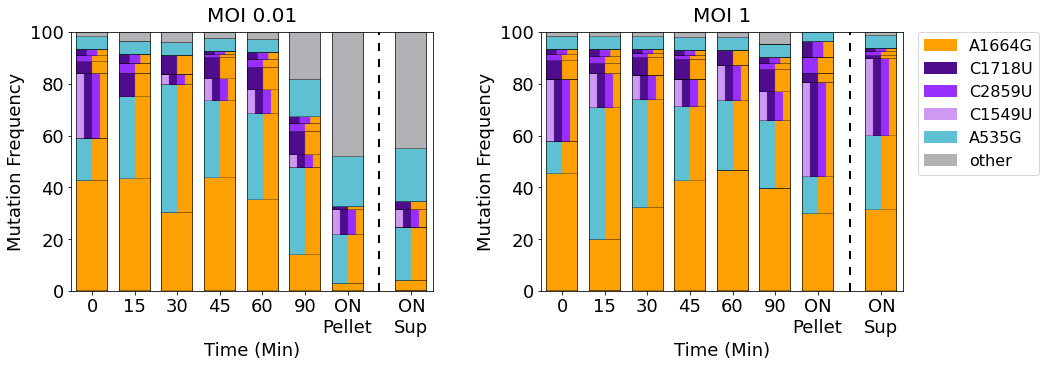

In [9]:
    # create stacked bar plots
    for exp in experiments:
        exp_freqs = all_freqs.loc[all_freqs["exp"] == exp, :]
        mutations_over_cutoff = exp_freqs.loc[(exp_freqs["freq"] >= cutoffs[0]) & 
                                              (exp_freqs["coverage"] >= cutoffs[1]) & 
                                              (exp_freqs["mut_name"].isin(muts_to_include)), :].reset_index(drop=True)
        # get a list of mutations over frequency cutoff in all MOIs
        mutations_ls = mutations_over_cutoff["mut_name"].sort_values().drop_duplicates().to_list()
        sample_ls = exp_freqs["sample_data"].sort_values().drop_duplicates().to_list()
        exp_samples = []
        test_samples = []
        for sample in sample_ls:
            # filter sample and keep required columns only
            sample_freqs = exp_freqs.loc[exp_freqs["sample_data"] == sample, ["mut_name", "time", "freq", "coverage"]].sort_values(["mut_name", "time"])
            times = sample_freqs["time"].sort_values().drop_duplicates().to_list()
            over_freqs = sample_freqs.loc[(sample_freqs["freq"] >= cutoffs[0]) & 
                                          (sample_freqs["coverage"] >= cutoffs[1]) & 
                                          (sample_freqs["mut_name"].isin(muts_to_include)), :].reset_index(drop=True)
            # mutations above cutoff in current MOI
            mutations = over_freqs["mut_name"].sort_values().drop_duplicates().to_list()
            sample_freqs = sample_freqs.loc[(sample_freqs["mut_name"].isin(mutations)) & 
                                            (sample_freqs["coverage"] >= cutoffs[1]), :].reset_index(drop=True)
            # fills 0 for missing values    
            stack_df = sample_freqs.set_index(['mut_name', 'time']).unstack(fill_value=0).stack().reset_index()
            # pivot df so each mut is a row and colums are timepoints
            df_pivot = stack_df.pivot(index='mut_name', columns='time', values='freq')
            # in this segment the assumptions mentioned above are applied
            temp_df = df_pivot.copy()
            temp_df.loc["other"] = 1 - temp_df.loc["A1664.0G"]
            temp_df.loc[["C1718.0T", "C2859.0T"]] -= temp_df.loc["C1549.0T"].values
            temp_df.loc[["C1718.0T", "C2859.0T"]] = temp_df.loc[["C1718.0T", "C2859.0T"]].clip(lower=0)
            temp_df.loc["triple"] = temp_df.loc["C2859.0T"] / 2
            temp_df.loc["C2859.0T"] /= 2
            temp_df.loc["C1718.0T"] -= temp_df.loc["triple"].values
            temp_df.loc["A1664.0G"] -= temp_df.loc[["C1549.0T", "C1718.0T", "C2859.0T", "triple"]].sum()
            # at moi 1 assumed that 5% of 535 is alone and the rest on orange
            # note: if "other" is less than 5%, 535 freq equals the "other" freq
            if sample == "moi1":
                new_row = {}
                for col in temp_df.columns:
                    new_row[col] = 0.05 if temp_df.at["other", col] >= 0.05 else temp_df.at["other", col]
                temp_df.loc["535_alone"] = new_row
                temp_df.loc["A535.0G"] -= temp_df.loc["535_alone"]
                temp_df.loc["A1664.0G"] -= temp_df.loc["A535.0G"]
                temp_df = temp_df.drop("other", axis=0)
            # for moi 0.01
            elif sample == "moi0.01":
                temp_df.loc["A535.0G", 15] = 0.3667 # freqs according to reseq sample
                # times 0 to 60 are the same as moi 1
                light_blue_row = {}
                for col in [0, 15, 30, 45, 60]:
                    light_blue_row[col] = 0.05 if temp_df.at["other", col] >= 0.05 else temp_df.at["other", col]
                for col2 in [90, 120, 150]:
                    light_blue_row[col2] = np.nan
                temp_df.loc["535_alone"] = light_blue_row
                temp_df.loc["A535.0G", [0, 15, 30, 45, 60]] -= temp_df.loc["535_alone"]
                temp_df.loc["A1664.0G", [0, 15, 30, 45, 60]] -= temp_df.loc["A535.0G"]
                # 535+1664 freq in t90 is equal to t60
                orange_535_val = temp_df.at["A535.0G", 60]
                alone_535_val = temp_df.at["A535.0G", 90] - orange_535_val
                temp_df.loc["535_alone", 90] = alone_535_val
                temp_df.loc["A535.0G", 90] = orange_535_val
                temp_df.loc["A1664.0G", 90] -= orange_535_val
                # in samples of ON we assume that 535 is 50% on its own and 50% with orange
                # note: if "other" is less than the amount of 535 alone , 535 freq equals the "other" freq and the rest was moved to 535+1664
                new_535_values = 0.5 * temp_df.loc["A535.0G", [120, 150]]
                other_values = temp_df.loc["other", [120, 150]]
                adjusted_values = np.minimum(new_535_values, other_values)
                temp_df.loc["535_alone", [120, 150]] = adjusted_values
                temp_df.loc["A535.0G", [120, 150]] = temp_df.loc["A535.0G", [120, 150]] - temp_df.loc["535_alone", [120, 150]]
                temp_df.loc["A1664.0G", [120, 150]] -= temp_df.loc["A535.0G", [120, 150]]
                temp_df = temp_df.drop("other", axis=0)    
            
            exp_samples.append((temp_df, sample))
        
        plot_freqs(exp_samples, output_path, mutations_ls, times, exp, cutoffs)
